In [1]:
from typing import Callable, Dict
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
import math

# GWAS summary statistic clustering
Data will be encoded into a standardized representation and then clustered to derive potential condition associations.

## Load & encode data

In [2]:
METADATA_FILE = 'gwas_trait_metadata.csv'
CLEANED_FILE_SUFFIX = '.csv'
UNKNOWN_GENE = "UNKNOWN"

metadata_df = pd.read_csv(METADATA_FILE)
all_traits = metadata_df['Trait'].tolist()
print(all_traits)

['attention deficit hyperactivity disorder', 'alzheimer disease', 'anxiety disorder', 'autism spectrum disorder', 'bipolar disorder', 'drug dependence', 'eating disorder', 'personality disorder', 'schizophrenia', 'tourette syndrome', 'unipolar depression']


In [3]:
def trait_to_cleaned_filename(trait):
    return trait.replace(" ", "_") + CLEANED_FILE_SUFFIX


def filter_unknown_genes(df):
  return df.loc[df['gene'] != UNKNOWN_GENE]


dfs = []
for trait in all_traits:
  df = pd.read_csv(trait_to_cleaned_filename(trait))
  df = filter_unknown_genes(df)
  if trait == 'attention deficit hyperactivity disorder':
    trait = 'ADHD'
  df['parent_trait'] = trait
  dfs.append(df)

### Naive encoding
Just use 1-hot encoding of gene implication (i.e. number all genes implicated in the given conditions from 0...N-1. Then create an N-dimensional vector for each condition where element i is 1 if the condition is associated with that gene, 0 if not).
The hypothesis is that similar conditions have implicated gene overlap.

In [4]:
def create_gene_to_index_dict(all_data_df: pd.DataFrame) -> Dict[str, int]:
  """Maps gene to index such that each gene is assigned a unique index."""
  all_genes = set()
  genes = all_data_df['gene'].unique()
  [all_genes.add(gene) for gene in genes]

  all_genes_list = list(all_genes)
  num_genes = len(all_genes_list)
  gene_to_index = {all_genes_list[i]: i for i in range(num_genes)}
  return gene_to_index

gene_to_index = create_gene_to_index_dict(pd.concat([df for df in dfs]))
print(f"Found {len(gene_to_index.keys())} total genes.")

Found 3259 total genes.


In [5]:
def encode_condition_df(df, gene_to_index):
  num_genes = len(gene_to_index.keys())
  vec = np.zeros(num_genes)
  condition_genes = df['gene'].unique()
  for gene in condition_genes:
    gene_index = gene_to_index[gene]
    vec[gene_index] = 1
  return vec


# Small test:
apoe_index = gene_to_index['APOE']
df = pd.DataFrame([{'variant_and_allele': 'test', 'p_value': 0.01, 'trait': 'test', 'gene': 'APOE'}])
encoding = encode_condition_df(df, gene_to_index)
assert encoding[apoe_index] == 1
assert sum(encoding) == 1

In [6]:
# Encode them all!
encodings_vertical = pd.DataFrame({df['parent_trait'].unique()[0]: encode_condition_df(df, gene_to_index) for df in dfs})
encodings_vertical

,ADHD,alzheimer disease,anxiety disorder,autism spectrum disorder,bipolar disorder,drug dependence,eating disorder,personality disorder,schizophrenia,tourette syndrome,unipolar depression
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
3254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3255,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3256,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [7]:
# Actually needs to have vectors as rows not columns:
encodings = encodings_vertical.T
encodings

,0,1,2,3,4,5,6,7,8,9,...,3249,3250,3251,3252,3253,3254,3255,3256,3257,3258
ADHD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
alzheimer disease,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
anxiety disorder,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
autism spectrum disorder,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bipolar disorder,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
drug dependence,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
eating disorder,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
personality disorder,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
schizophrenia,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
tourette syndrome,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Naive Clustering (no special filtering)

In [8]:
# See docs here:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
model = AgglomerativeClustering(distance_threshold=0, 
                                n_clusters=None, 
                                linkage='ward')
clustering = model.fit(encodings)

In [9]:
# This code is from the scikit-learn examples!
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

def plot_dendrogram(model, conditions, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs, labels=conditions, leaf_rotation=90)

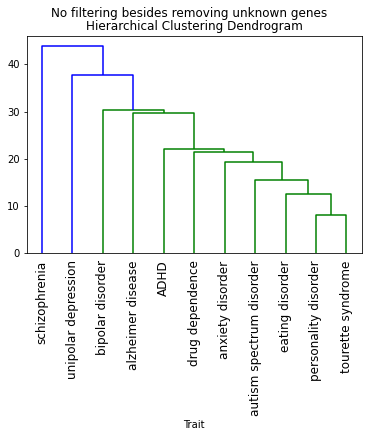

In [10]:
plt.suptitle('No filtering besides removing unknown genes')
plt.title("Hierarchical Clustering Dendrogram")
# plot all levels of the dendrogram
plot_dendrogram(model, encodings_vertical.columns, truncate_mode="level", p=11)
plt.xlabel("Trait")
plt.show()

### Observations
It seems schizophrenia is the least similar to the others. This is a little surprising given that in my literature review I saw many mentions of Schizophrenia having overlap with other mental illnesses. The results may be skewed at this time because there is more data for schizophrenia.

The telescoping shape also seems peculiar (as opposed to distinct subgroups). The ordering seems to be (from left to right) traits with the most data points to traits with the least. Let's double-check:

In [11]:
trait_to_num_data_points = {}
for df in dfs:
  trait = df['parent_trait'].unique()[0]
  num_rows = len(df)
  trait_to_num_data_points[trait] = num_rows

{k: v for v, k in sorted(
    trait_to_num_data_points.items(), key=lambda item: item[1])}

{27: 'personality disorder',
 37: 'tourette syndrome',
 109: 'eating disorder',
 163: 'autism spectrum disorder',
 234: 'anxiety disorder',
 317: 'drug dependence',
 380: 'ADHD',
 724: 'alzheimer disease',
 748: 'bipolar disorder',
 1142: 'unipolar depression',
 1954: 'schizophrenia'}

Yes, the clustering hierarchy almost perfectly resembles how many data points there are per trait. This makes sense based on vector magnitudes.

## Less naive clustering
Drop personality disorder and tourette syndrome as they likely don't have enough data to be meaningful compared to the other traits (also, from the post-cleaning analysis, it seems personality disorder variants have high p-values compared to all other conditions).

In [12]:
excluded_traits = ['personality disorder', 'tourette syndrome']
all_df = pd.concat(df for df in dfs if df['parent_trait'].unique()[0] not in excluded_traits)
all_df['parent_trait'].unique()

array(['ADHD', 'alzheimer disease', 'anxiety disorder',
       'autism spectrum disorder', 'bipolar disorder', 'drug dependence',
       'eating disorder', 'schizophrenia', 'unipolar depression'],
      dtype=object)

In [13]:
# Combine some of the code above into a reusable function
def gene_based_hierachical_clustering(all_df, title):
  traits = all_df['parent_trait']
  trait_dfs = [all_df.loc[all_df['parent_trait'] == trait] for trait in traits]
  encodings_vertical = pd.DataFrame({df['parent_trait'].unique()[0]: encode_condition_df(df, gene_to_index) for df in trait_dfs})
  encodings = encodings_vertical.T
  model = AgglomerativeClustering(distance_threshold=0,
                                  n_clusters=None, 
                                  linkage='ward')
  model.fit(encodings)

  plt.suptitle(title)
  plt.title("Hierarchical Clustering Dendrogram")
  # plot all levels of the dendrogram
  plot_dendrogram(model, encodings_vertical.columns, truncate_mode="level", p=11)
  plt.xlabel('Trait')
  plt.show()

Try again to see if there's any difference...
One hypothesis is that only genes that appear in multiple traits are relevant to include in the encoding and clustering, because genes that are only implicated by one trait only show 'difference' from other traits...
but on the other hand, if a trait has only one gene in common with others and hundreds of other unique implicated genes, it could be informative that the trait is actually quite different. Let's try both, starting with all genes.

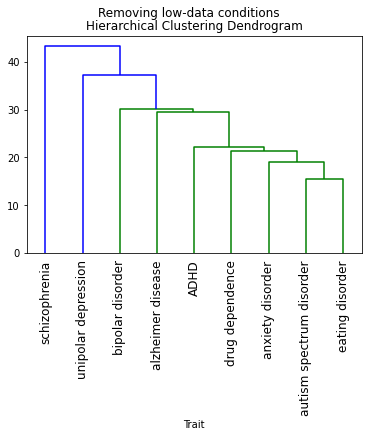

In [14]:
gene_based_hierachical_clustering(all_df, 'Removing low-data conditions')

Still in order of data points. Probably need to do some sort of normalization based on data size. Let's first filter out genes that only appear in one trait though. If we're measuring similarity, unique genes don't really add information, or at least it's not clear how to account for that in an unbiased way.

In [15]:
all_genes = all_df['gene'].unique()
# Stores genes that only appear for one trait
genes_to_remove = []
for gene in all_genes:
  num_traits = len(all_df.loc[all_df['gene'] == gene])
  if num_traits < 2:
    genes_to_remove.append(gene)

print(f'{len(genes_to_remove)} / {len(all_genes)} only appear in a single trait')

2227 / 3213 only appear in a single trait


That's a good chunk of the genes, but let's proceed...

In [16]:
print(f'Initial df size: {len(all_df)}')

def is_common_gene(gene):
  return gene not in genes_to_remove


is_common_index = all_df['gene'].map(is_common_gene)
all_df = all_df.loc[is_common_index]
len(all_df)

Initial df size: 5771


3544

Actually not that many data points were removed. Finally cluster this data:

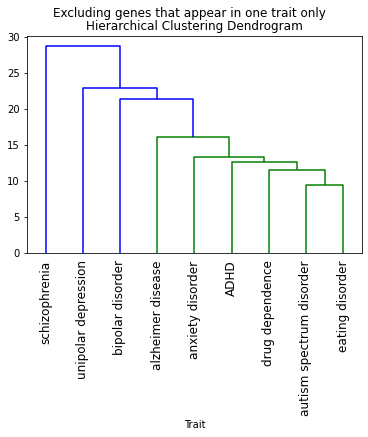

In [17]:
gene_based_hierachical_clustering(all_df, 
                                  'Excluding genes that appear in one trait only')

Well, a slightly different order of the telescoping effect, but still no distinct clusters.

## Account for data size
Vector magnitude (number of data points per condition) seems to be biasing clustering results. Try taking top X data points per trait where X is the number of data points for the trait with the smallest dataset size, and 'top' means lowest p-value variant associations.

In [18]:
trait_group_df = all_df.groupby('parent_trait').size()
trait_group_df

parent_trait
ADHD                         209
alzheimer disease            382
anxiety disorder             115
autism spectrum disorder      80
bipolar disorder             511
drug dependence              141
eating disorder               41
schizophrenia               1392
unipolar depression          673
dtype: int64

In [19]:
smallest_trait_size = trait_group_df.min()
smallest_trait_size

41

In [20]:
new_df = pd.DataFrame()
for trait in all_df['parent_trait'].unique():
  trait_df = all_df[all_df['parent_trait'] == trait]
  trait_df.sort_values(by='p_value', 
                       inplace=True, 
                       ascending=True)
  trait_df = trait_df.iloc[range(0, smallest_trait_size)]
  new_df = pd.concat([new_df, trait_df])

trait_group_df = new_df.groupby('parent_trait').size()
trait_group_df

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


parent_trait
ADHD                        41
alzheimer disease           41
anxiety disorder            41
autism spectrum disorder    41
bipolar disorder            41
drug dependence             41
eating disorder             41
schizophrenia               41
unipolar depression         41
dtype: int64

Now try clustering with most significant associations for common genes per trait.

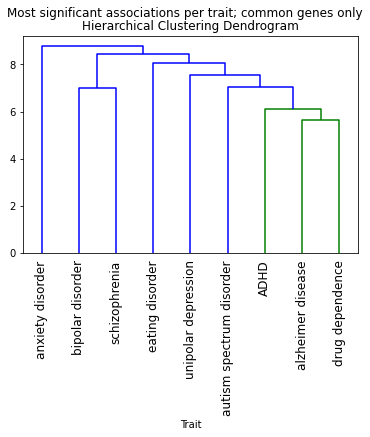

In [21]:
gene_based_hierachical_clustering(new_df, 
                                  'Most significant associations per trait; common genes only')

Well, it's not sorted by magnitude anymore! Bipolar and schizophrenia are clustered together, which is also reported in the literature. I need to look into this a bit, but the association between Alzheimer's and drug dependence seems plausible too.

## Experiment with different gene-based encodings

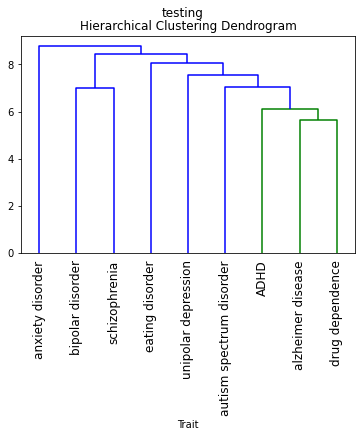

In [22]:
# Abstract the function from above slightly more to take in an encoding function
def hierachical_clustering(
    all_df: pd.DataFrame,
    title: str,
    encode: Callable[[pd.DataFrame], pd.DataFrame]) -> None:
  encodings_vertical = encode(all_df)
  encodings = encodings_vertical.T
  model = AgglomerativeClustering(distance_threshold=0,
                                  n_clusters=None, 
                                  linkage='ward')
  model.fit(encodings)

  plt.suptitle(title)
  plt.title("Hierarchical Clustering Dendrogram")
  # plot all levels of the dendrogram
  plot_dendrogram(model, encodings_vertical.columns, truncate_mode="level", p=11)
  plt.xlabel('Trait')
  plt.show()


# Copy code from above to test generalized clustering function.
def one_hot_gene_encoding(in_df: pd.DataFrame) -> pd.DataFrame:
  traits = in_df['parent_trait']
  trait_dfs = [in_df.loc[in_df['parent_trait'] == trait] for trait in traits]
  return pd.DataFrame({df['parent_trait'].unique()[0]: encode_condition_df(df, gene_to_index) for df in trait_dfs})


hierachical_clustering(new_df, 'testing', one_hot_gene_encoding)

In [23]:
def implicated_gene_weighted_encoding(in_df: pd.DataFrame) -> pd.DataFrame:
  """Encodes trait vectors where elements are relative gene implications.

  Specifically, for each trait, creates a vector (V1, V2... Vn) 
  where Vi = Gi/Max(Gi) where a trait has Gi variants implicated with ith gene
  and n is total genes in `in_df`.
  
  E.g. if trait has gene associations:
    gene1  gene2  gene3
    1      3      5

  Then encoding is:
   (.2,   .6,     1)

   DataFrame is returned with traits as column headers and vectors as columns.
  """
  gene_to_index = create_gene_to_index_dict(in_df)
  traits = in_df['parent_trait']
  trait_dfs = [in_df.loc[in_df['parent_trait'] == trait] for trait in traits]
  trait_to_encoding = {}
  for trait_df in trait_dfs:
    trait = trait_df['parent_trait'].unique()[0]
    gene_counts_encoding = weighted_gene_encoding(trait_df, gene_to_index)
    max_val = max(gene_counts_encoding)
    gene_counts_encoding = gene_counts_encoding / max_val
    trait_to_encoding[trait] = gene_counts_encoding
  return pd.DataFrame(trait_to_encoding)


def weighted_gene_encoding(
    trait_df: pd.DataFrame, gene_to_index: Dict[str, int]) -> np.ndarray:
  num_genes = len(gene_to_index.keys())
  vec = np.zeros(num_genes)
  trait_genes = trait_df['gene']
  for gene in trait_genes:
    gene_index = gene_to_index[gene]
    vec[gene_index] += 1
  return vec

In [24]:
# Test encoding function:
implicated_gene_weighted_encoding(all_df)

,ADHD,alzheimer disease,anxiety disorder,autism spectrum disorder,bipolar disorder,drug dependence,eating disorder,schizophrenia,unipolar depression
0,0.000000,0.000000,0.25,0.0,0.0,0.000000,0.0,0.000000,0.071429
1,0.000000,0.000000,0.00,0.0,0.0,0.000000,0.0,0.095238,0.000000
2,0.000000,0.000000,0.00,0.0,0.0,0.058824,0.0,0.000000,0.214286
3,0.000000,0.000000,0.00,0.0,0.0,0.000000,0.0,0.142857,0.000000
4,0.000000,0.000000,0.25,0.0,0.2,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
981,0.000000,0.095238,0.00,0.0,0.0,0.000000,0.0,0.000000,0.000000
982,0.000000,0.000000,0.00,0.0,0.0,0.000000,0.0,0.047619,0.071429
983,0.000000,0.047619,0.00,0.0,0.0,0.000000,0.0,0.000000,0.071429
984,0.066667,0.000000,0.25,0.0,0.0,0.000000,0.0,0.000000,0.000000


In [25]:
implicated_gene_weighted_encoding(all_df)['schizophrenia'].unique()

array([0.        , 0.0952381 , 0.14285714, 0.04761905, 0.33333333,
       0.19047619, 0.23809524, 0.28571429, 0.38095238, 0.42857143,
       0.47619048, 0.71428571, 0.52380952, 1.        ])

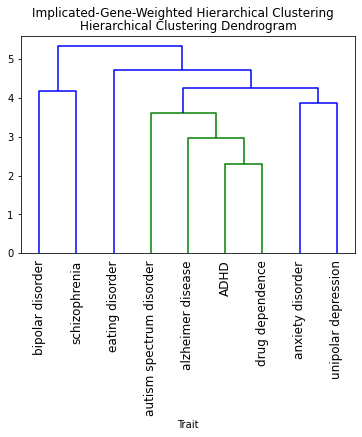

In [26]:
hierachical_clustering(
    all_df,
    'Implicated-Gene-Weighted Hierarchical Clustering',
    implicated_gene_weighted_encoding)

Observations:


*   Seems quite similar to the previous one, except anxiety disorder and unipolar depression are adjacent here.
*   In the previous clustering, anxiety disorder was separated from all other traits, whereas here bipolar disorder and schizophrenia are clustered together and away from all others.
*   I think this encoding is better in that it utilizes as much data as possible (not filtering to min p-values, just removing low-data conditions) but still accounts for bias in varying amounts of data for each condition.



### Try same approach with AF filtering first.

Under the assumption these disorders affect a minority of the population, filter to variants with < 0.5 AF.

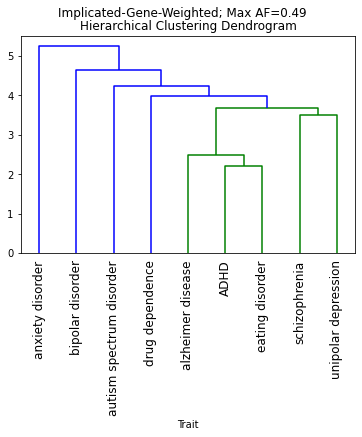

In [27]:
def filter_by_af(
    in_df: pd.DataFrame, 
    max_af = None, 
    min_af = None) -> pd.DataFrame:
  """Returns copy of `in_df` where `af` column is bounded by min/max AF."""
  out_df = in_df.copy()
  if max_af is not None:
    out_df = out_df[out_df['af'] <= max_af]
  if min_af is not None:
    out_df = out_df[out_df['af'] >= min_af]
  return out_df


# If we're utilizing AF, need to exclude those with unknown AF value, 
# i.e. those with values of -1.
hierachical_clustering(
    filter_by_af(all_df, min_af=0.0, max_af=.49),
    'Implicated-Gene-Weighted; Max AF=0.49',
    implicated_gene_weighted_encoding)

Similar to previous except eating disorder is now closer to ADHD and alzheimer, and schizophrenia and unipolar depression are less separated from the rest of the traits. Recalling from the post-cleaning analysis though, most of eating disorder variants had AF > 0.5, so this may be noise from low-data.

In [28]:
minority_df = filter_by_af(all_df, min_af=0.0, max_af=.49)
len(minority_df[minority_df['parent_trait'] == 'eating disorder'])

10

Yeah... may be best to exclude eating disorder as well since these 
were near-outliers according to the post-cleaning analysis.

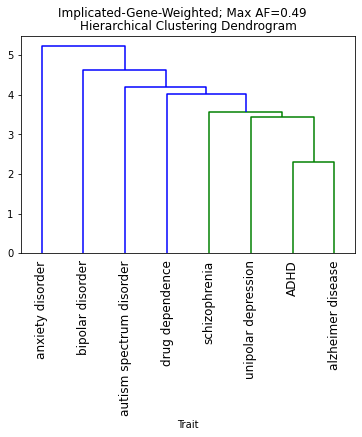

In [29]:
minority_df = minority_df[minority_df['parent_trait'] != 'eating disorder']
hierachical_clustering(
    minority_df,
    'Implicated-Gene-Weighted; Max AF=0.49',
    implicated_gene_weighted_encoding)

According to a [paper](https://www.frontiersin.org/articles/10.3389/fgene.2020.00679/full) I read, excluding SNPs with AF < 0.01 may be viable too. My assumption is these may be 'too rare' to play a role in common(ish) traits.

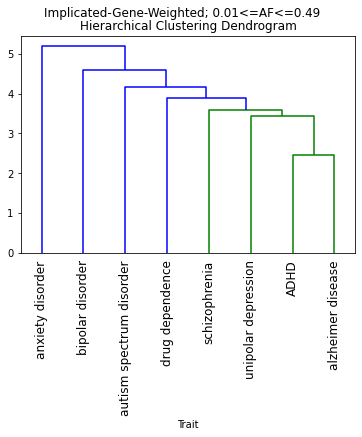

In [30]:
min_and_max_filtered_df = filter_by_af(minority_df, min_af=0.01)
hierachical_clustering(
    min_and_max_filtered_df,
    'Implicated-Gene-Weighted; 0.01<=AF<=0.49',
    implicated_gene_weighted_encoding)

Interestingly, this really changes the structure. Double-check how much data is being filtered at each step.

In [31]:
pre_af_filtering_size = len(all_df)
max_af_filtering_size = len(minority_df) # this also removed eating disorder
min_and_max_filtering_size = len(min_and_max_filtered_df)

print(f'{pre_af_filtering_size} variants before AF filtering.')
print(f'{max_af_filtering_size} variants with max AF filtering.')
print(f'{min_and_max_filtering_size} variants with min and max AF filtering.')

3544 variants before AF filtering.
1278 variants with max AF filtering.
1237 variants with min and max AF filtering.


About a third of original variants remaining after min & max AF filtering. Check for condition skew

In [32]:
min_and_max_filtered_df.groupby('parent_trait').size().sort_values()

parent_trait
autism spectrum disorder     36
drug dependence              51
anxiety disorder             58
ADHD                         83
alzheimer disease           115
bipolar disorder            178
unipolar depression         296
schizophrenia               420
dtype: int64

Still at least 30 rows per trait.

In [33]:
# Just double-checking the logic.
min_and_max_filtered_df['af'].describe()

count    1237.000000
mean        0.257523
std         0.140542
min         0.010266
25%         0.133620
50%         0.275067
75%         0.378422
max         0.489979
Name: af, dtype: float64

What if we focus on rarest variants only?

In [34]:
rare_df = filter_by_af(all_df, min_af=0.0, max_af=.01)
len(rare_df)

41

Probably not enough data points for meaningful clustering. Let's just look at the conditions with significant rare variants.

In [35]:
rare_df.groupby('parent_trait').size().sort_values()

parent_trait
anxiety disorder             1
autism spectrum disorder     1
bipolar disorder             3
drug dependence              4
schizophrenia                4
unipolar depression          6
alzheimer disease           22
dtype: int64

Surprisingly, alzheimer disease actually has more significant rare (AF <= 0.01) variants than schizophrenia, even though schizophrenia has more known significant variants (by more than 2x according to post-cleaning analysis).

# Tissue-association based clustering

Re-using some code from post-cleaning analysis to get started with tissue associated variants. Total numbers may be different as low-data traits have already been filtered.

In [36]:
TISSUE_DELIM = "&"

all_df['tissues'] = all_df['tissues'].fillna('')

tissue_metadata_file = 'tissue_metadata.txt'
all_tissues = []
with open(tissue_metadata_file) as tissue_file:
  for tissue in tissue_file.readlines():
    all_tissues.append(tissue.replace("\n", ""))

print(f'Tissues: {all_tissues}')

# In previous cleaning, if a variant mapped to multiple genes, I created 
# separate rows for it. For tissue association I just blindly match the variant
# location and don't care about the gene though... so drop duplicate locations
# as they may misrepresent total counts in subsequent tissue analysis here.
tissues_df = all_df.copy()
tissues_df.drop_duplicates(subset=['location', 'parent_trait'], inplace=True)
total_variants = len(tissues_df)
tissues_df['has_tissues'] = tissues_df['tissues'].map(lambda tissues: len(tissues) > 0)
tissues_df = tissues_df[tissues_df['has_tissues'] == True]
num_variants_with_tissues = len(tissues_df)
print(f'{num_variants_with_tissues} variants significantly associated with tissues of {total_variants} total.')

# Aggregate number of per-tissue associations per trait.
# This is a dict from trait to Dict[tissue, tissue association count]
trait_to_tissue_to_count = {}
all_traits = tissues_df['parent_trait'].unique()
for trait in all_traits:
  trait_to_tissue_to_count[trait] = {tissue: 0 for tissue in all_tissues}

for _, row in tissues_df.iterrows():
  trait = row['parent_trait']
  variant_tissues = row['tissues'].split(TISSUE_DELIM)
  for tissue in variant_tissues:
    trait_to_tissue_to_count[trait][tissue] += 1

rows = []
index = []
for trait, tissue_dict in trait_to_tissue_to_count.items():
  index.append(trait)
  rows.append(tissue_dict)

trait_to_tissue_count_df = pd.DataFrame(rows, index=index)
trait_to_tissue_count_df.head()

Tissues: ['Adipose_Subcutaneous', 'Adipose_Visceral_Omentum', 'Adrenal_Gland', 'Artery_Aorta', 'Artery_Coronary', 'Artery_Tibial', 'Brain_Amygdala', 'Brain_Anterior_cingulate_cortex_BA24', 'Brain_Caudate_basal_ganglia', 'Brain_Cerebellar_Hemisphere', 'Brain_Cerebellum', 'Brain_Cortex', 'Brain_Frontal_Cortex_BA9', 'Brain_Hippocampus', 'Brain_Hypothalamus', 'Brain_Nucleus_accumbens_basal_ganglia', 'Brain_Putamen_basal_ganglia', 'Brain_Spinal_cord_cervical_c-1', 'Brain_Substantia_nigra', 'Breast_Mammary_Tissue', 'Cells_Cultured_fibroblasts', 'Cells_EBV-transformed_lymphocytes', 'Colon_Sigmoid', 'Colon_Transverse', 'Esophagus_Gastroesophageal_Junction', 'Esophagus_Mucosa', 'Esophagus_Muscularis', 'Heart_Atrial_Appendage', 'Heart_Left_Ventricle', 'Kidney_Cortex', 'Liver', 'Lung', 'Minor_Salivary_Gland', 'Muscle_Skeletal', 'Nerve_Tibial', 'Ovary', 'Pancreas', 'Pituitary', 'Prostate', 'Skin_Not_Sun_Exposed_Suprapubic', 'Skin_Sun_Exposed_Lower_leg', 'Small_Intestine_Terminal_Ileum', 'Spleen', 

,Adipose_Subcutaneous,Adipose_Visceral_Omentum,Adrenal_Gland,Artery_Aorta,Artery_Coronary,Artery_Tibial,Brain_Amygdala,Brain_Anterior_cingulate_cortex_BA24,Brain_Caudate_basal_ganglia,Brain_Cerebellar_Hemisphere,...,Skin_Not_Sun_Exposed_Suprapubic,Skin_Sun_Exposed_Lower_leg,Small_Intestine_Terminal_Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole_Blood
ADHD,15,11,5,11,4,15,2,2,6,6,...,15,15,2,5,6,12,21,2,2,10
alzheimer disease,25,13,9,18,5,21,3,3,12,14,...,18,21,6,15,16,18,21,2,2,25
anxiety disorder,7,9,6,7,4,13,3,6,7,10,...,12,12,4,9,9,14,14,2,2,15
autism spectrum disorder,7,8,4,6,2,8,2,5,4,9,...,8,8,3,5,3,9,9,0,2,8
bipolar disorder,62,51,43,62,28,72,8,24,41,37,...,60,74,29,43,42,68,82,7,12,59


In [37]:
# Clustering approach for tissues will be very similar to the weighted gene 
# encoding, except now each element in a vector here represents 
# tissue associations instead of gene associations.

def implicated_tissue_weighted_encoding(in_df: pd.DataFrame) -> pd.DataFrame:
  """Encodes trait vectors where elements are relative tissue implications.

  Specifically, for each trait, creates a vector (V1, V2... Vn) 
  where Vi = Ti/Max(Ti) where a trait has Ti variants implicated with ith tissue
  and n is total tissues in `in_df`.
  
  E.g. if trait has tissue associations:
    tissue1  tissue2  tissue3
    1      3      5

  Then encoding is:
   (.2,   .6,     1)

   DataFrame is returned with traits as column headers and vectors as columns.
  """
  tissue_to_index = create_tissue_to_index_dict()
  traits = in_df.index.tolist()
  trait_to_encoding = {}
  for trait in traits:
    trait_row = in_df.loc[trait]
    tissue_counts_encoding = trait_row.to_numpy()
    max_val = max(tissue_counts_encoding)
    tissue_counts_encoding = tissue_counts_encoding / max_val
    trait_to_encoding[trait] = tissue_counts_encoding
  return pd.DataFrame(trait_to_encoding)


def create_tissue_to_index_dict() -> Dict[str, int]:
  """Maps tissue to index such that each tissue is assigned a unique index."""
  num_tissues = len(all_tissues)
  tissue_to_index = {all_tissues[i]: i for i in range(num_tissues)}
  return tissue_to_index


# Test
implicated_tissue_weighted_encoding(trait_to_tissue_count_df)

,ADHD,alzheimer disease,anxiety disorder,autism spectrum disorder,bipolar disorder,drug dependence,eating disorder,schizophrenia,unipolar depression
0,0.714286,1.00,0.466667,0.777778,0.756098,0.600000,0.333333,0.867704,0.961165
1,0.523810,0.52,0.600000,0.888889,0.621951,0.285714,0.000000,0.723735,0.825243
2,0.238095,0.36,0.400000,0.444444,0.524390,0.114286,0.000000,0.501946,0.660194
3,0.523810,0.72,0.466667,0.666667,0.756098,0.485714,0.333333,0.762646,0.708738
4,0.190476,0.20,0.266667,0.222222,0.341463,0.228571,0.000000,0.373541,0.456311
5,0.714286,0.84,0.866667,0.888889,0.878049,0.771429,0.333333,0.871595,0.951456
6,0.095238,0.12,0.200000,0.222222,0.097561,0.057143,0.000000,0.241245,0.203883
7,0.095238,0.12,0.400000,0.555556,0.292683,0.028571,0.000000,0.322957,0.359223
8,0.285714,0.48,0.466667,0.444444,0.500000,0.200000,0.333333,0.517510,0.718447
9,0.285714,0.56,0.666667,1.000000,0.451220,0.342857,0.000000,0.494163,0.679612


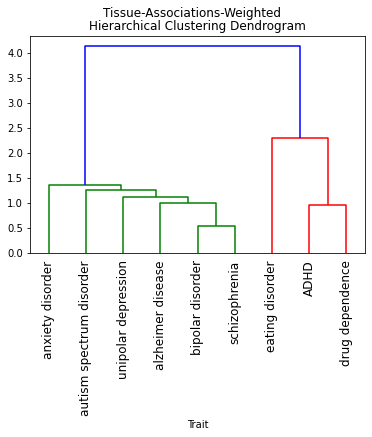

In [38]:
hierachical_clustering(
    trait_to_tissue_count_df,
    'Tissue-Associations-Weighted',
    implicated_tissue_weighted_encoding)

Actually quite different from other plots. The ADHD, eating disorder, drug dependence sub-cluster seems to be very distinct from the other group. Schizophrenia and bipolar disorder are still closely related.

Although normalizing the encoded values to the ranges 0-1 somewhat accounts for varying data sizes, it may not be sufficient since more data means more potential to have tissue associations, which could lead to denser vectors for these traits which may not actually have any clinical significance.